In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import os
from sklearn.decomposition import PCA

from dredFISH.Design import PNMF
from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import * 

import importlib
importlib.reload(PNMF)


<module 'dredFISH.Design.PNMF' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/PNMF.py'>

In [2]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'res_dpnmf/v_python'
print(res_dir)
fig_dir = prj_dir + 'figures/'

# data (old)
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'
adata = anndata.read_h5ad(f, backed='r') # library size normed (no log)
# X = np.array(adata.X.todense()).copy() # already library size normalized
# adata

# data (CPM with rep)
scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100.npy'
cell_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100_cells.csv'
clst_path        = '/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/smrt_withrep_X_subL5n100_y_L5.npy'

/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python


In [3]:
# allen scrna matrix (CPM; only 10k genes)
X = np.load(scrna_genes_path, allow_pickle=True).T # cell by gene
cells = pd.read_csv(cell_path)['0'].values
# X.sum(axis=1)
y_l5 = np.load(clst_path, allow_pickle=True)

logX = np.log10(X+1)
X.shape, logX.shape, y_l5.shape, cells.shape

((38200, 10861), (38200, 10861), (38200,), (38200,))

In [4]:
meta = adata.obs.copy()
meta = meta.loc[cells]
meta[['cluster_label', 'subclass_label', 'neighborhood_label', 'class_label']]

,cluster_label,subclass_label,neighborhood_label,class_label
SM-D9CZ6_S01_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
LS-15352_S16_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9EPN_S55_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-D9CZK_S30_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
SM-GE676_S016_E1-50,259_L5 PT CTX,L5 PT CTX,PT,Glutamatergic
...,...,...,...,...
SM-GE4XX_S291_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S182_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4WM_S007_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic
SM-GE4XV_S189_E1-50,262_L4 RSP-ACA,L4 RSP-ACA,PT,Glutamatergic


In [5]:
# get the S matrix
ctrds_l3, types_l3 = basicu.group_mean(X, meta['subclass_label'].values)
print(ctrds_l3.shape)
print(types_l3)

ctrds_l2, types_l2 = basicu.group_mean(X, meta['neighborhood_label'].values)
print(ctrds_l2.shape)
print(types_l2)

ctrds_l1, types_l1 = basicu.group_mean(X, meta['class_label'].values)
print(ctrds_l1.shape)
print(types_l1)

(42, 10861)
['Astro' 'CA1-ProS' 'CA2-IG-FC' 'CA3' 'CR' 'CT SUB' 'Car3' 'DG' 'Endo'
 'L2 IT ENTl' 'L2 IT ENTm' 'L2/3 IT CTX' 'L2/3 IT ENTl' 'L2/3 IT PPP'
 'L2/3 IT RHP' 'L3 IT ENT' 'L4 RSP-ACA' 'L4/5 IT CTX' 'L5 IT CTX' 'L5 PPP'
 'L5 PT CTX' 'L5/6 IT TPE-ENT' 'L5/6 NP CTX' 'L6 CT CTX' 'L6 IT CTX'
 'L6 IT ENTl' 'L6b CTX' 'L6b/CT ENT' 'Lamp5' 'Meis2' 'Micro-PVM' 'NP PPP'
 'NP SUB' 'Oligo' 'Pvalb' 'SMC-Peri' 'SUB-ProS' 'Sncg' 'Sst' 'Sst Chodl'
 'VLMC' 'Vip']
(8, 10861)
['CGE' 'DG/SUB/CA' 'L2/3 IT' 'L4/5/6 IT Car3' 'MGE' 'NP/CT/L6b' 'Other'
 'PT']
(3, 10861)
['GABAergic' 'Glutamatergic' 'Non-Neuronal']


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


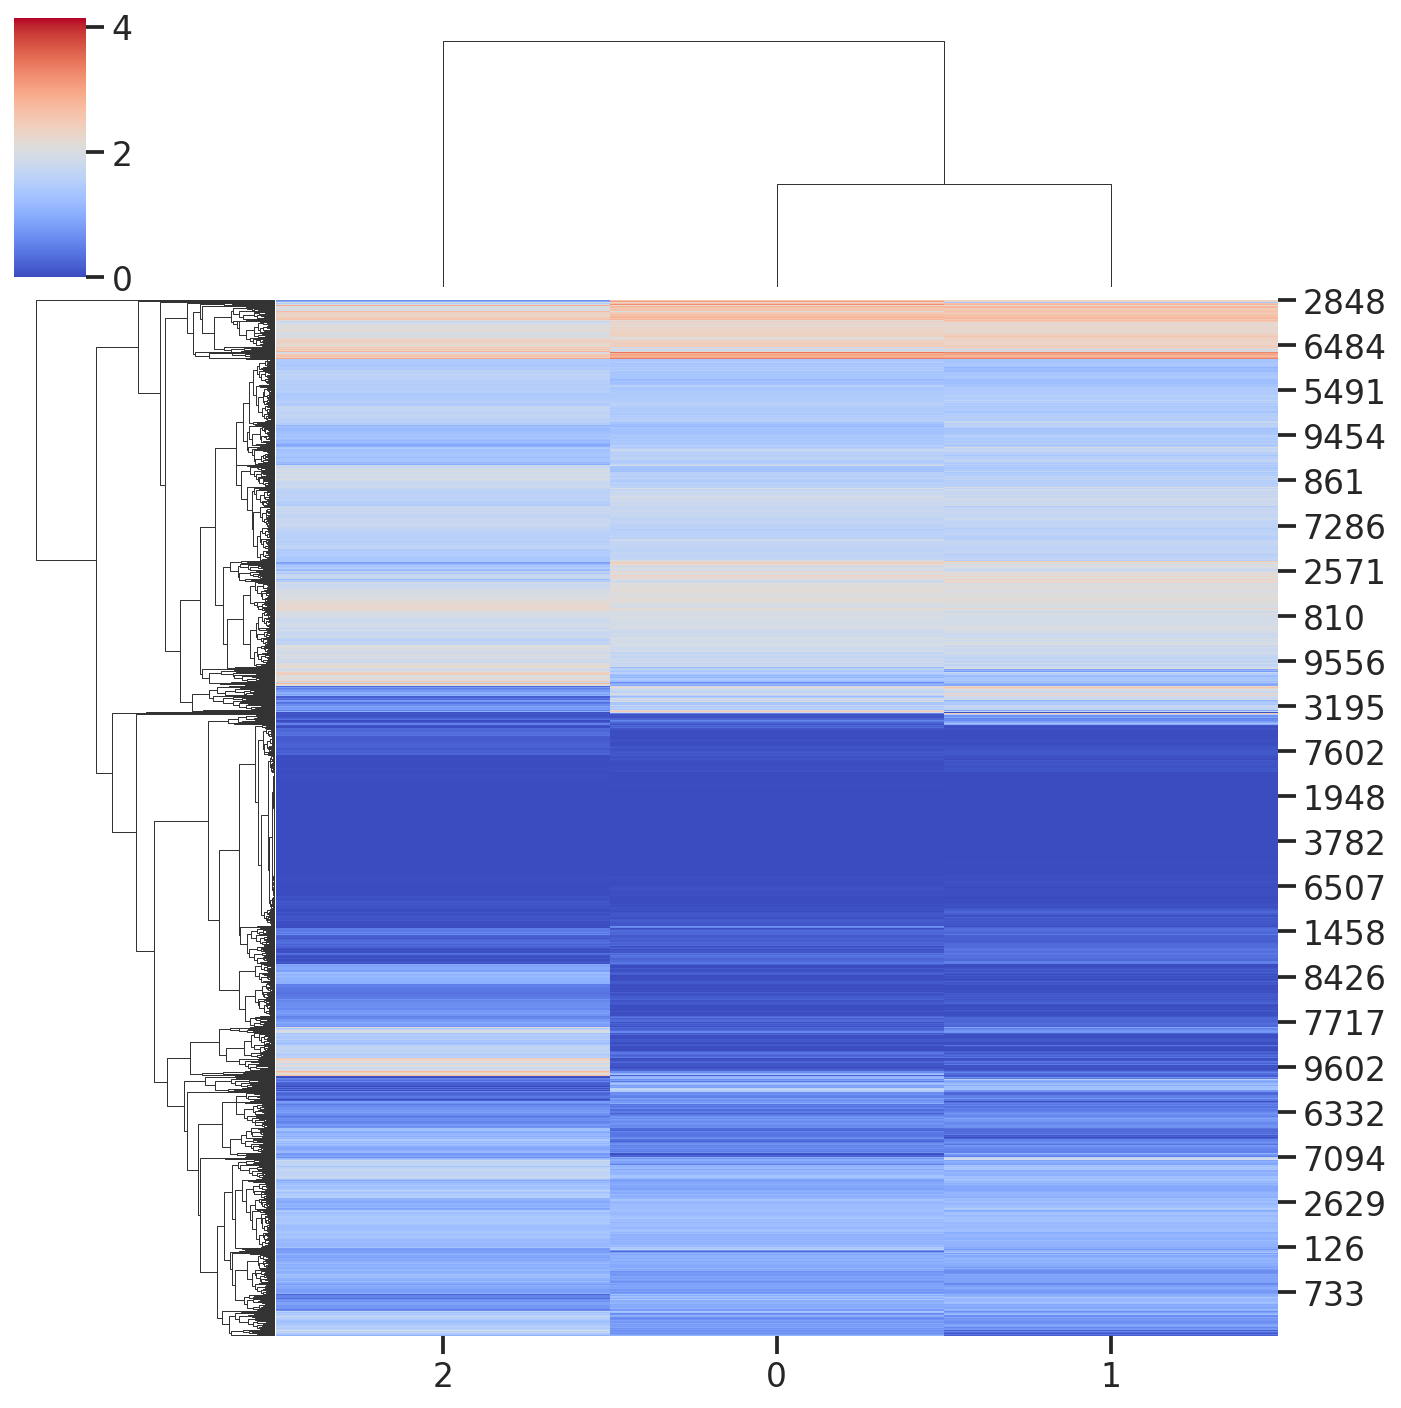

In [6]:
sns.clustermap(np.log10(ctrds_l1.T+1), cmap='coolwarm')

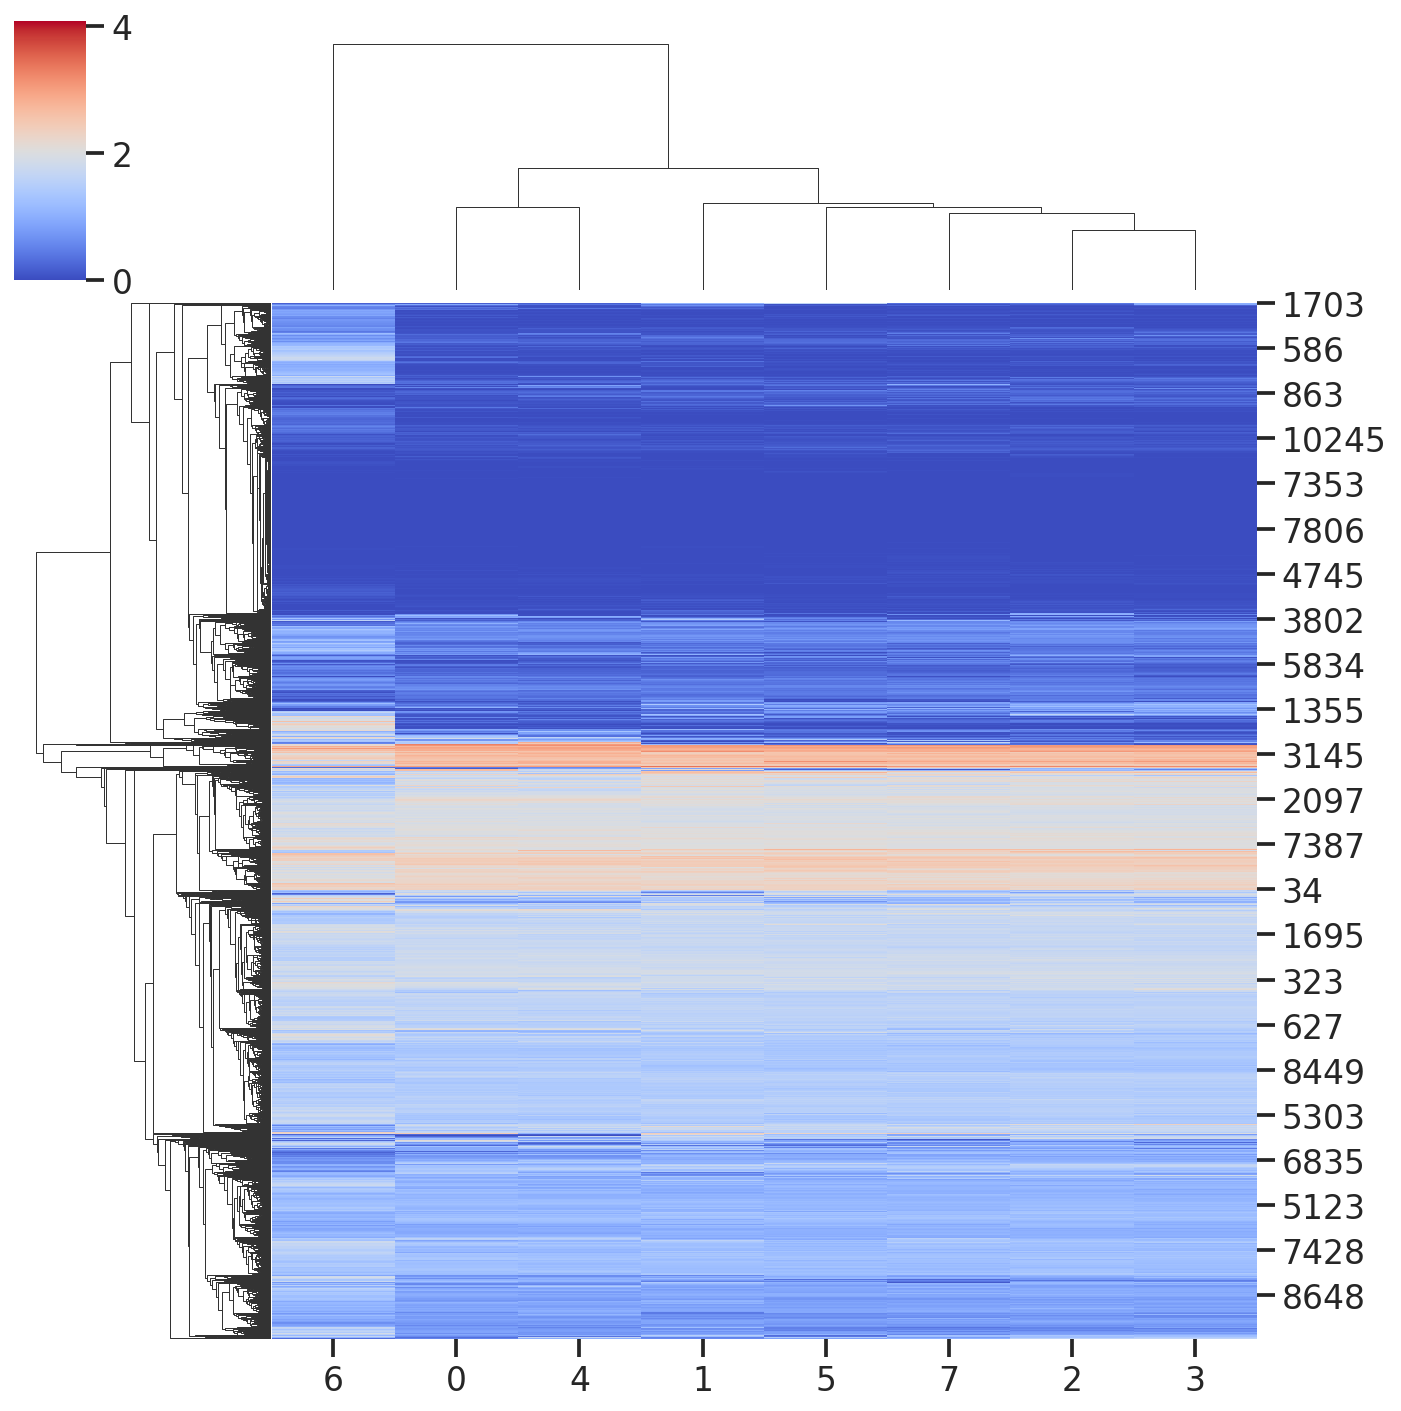

In [7]:
sns.clustermap(np.log10(ctrds_l2.T+1), cmap='coolwarm')

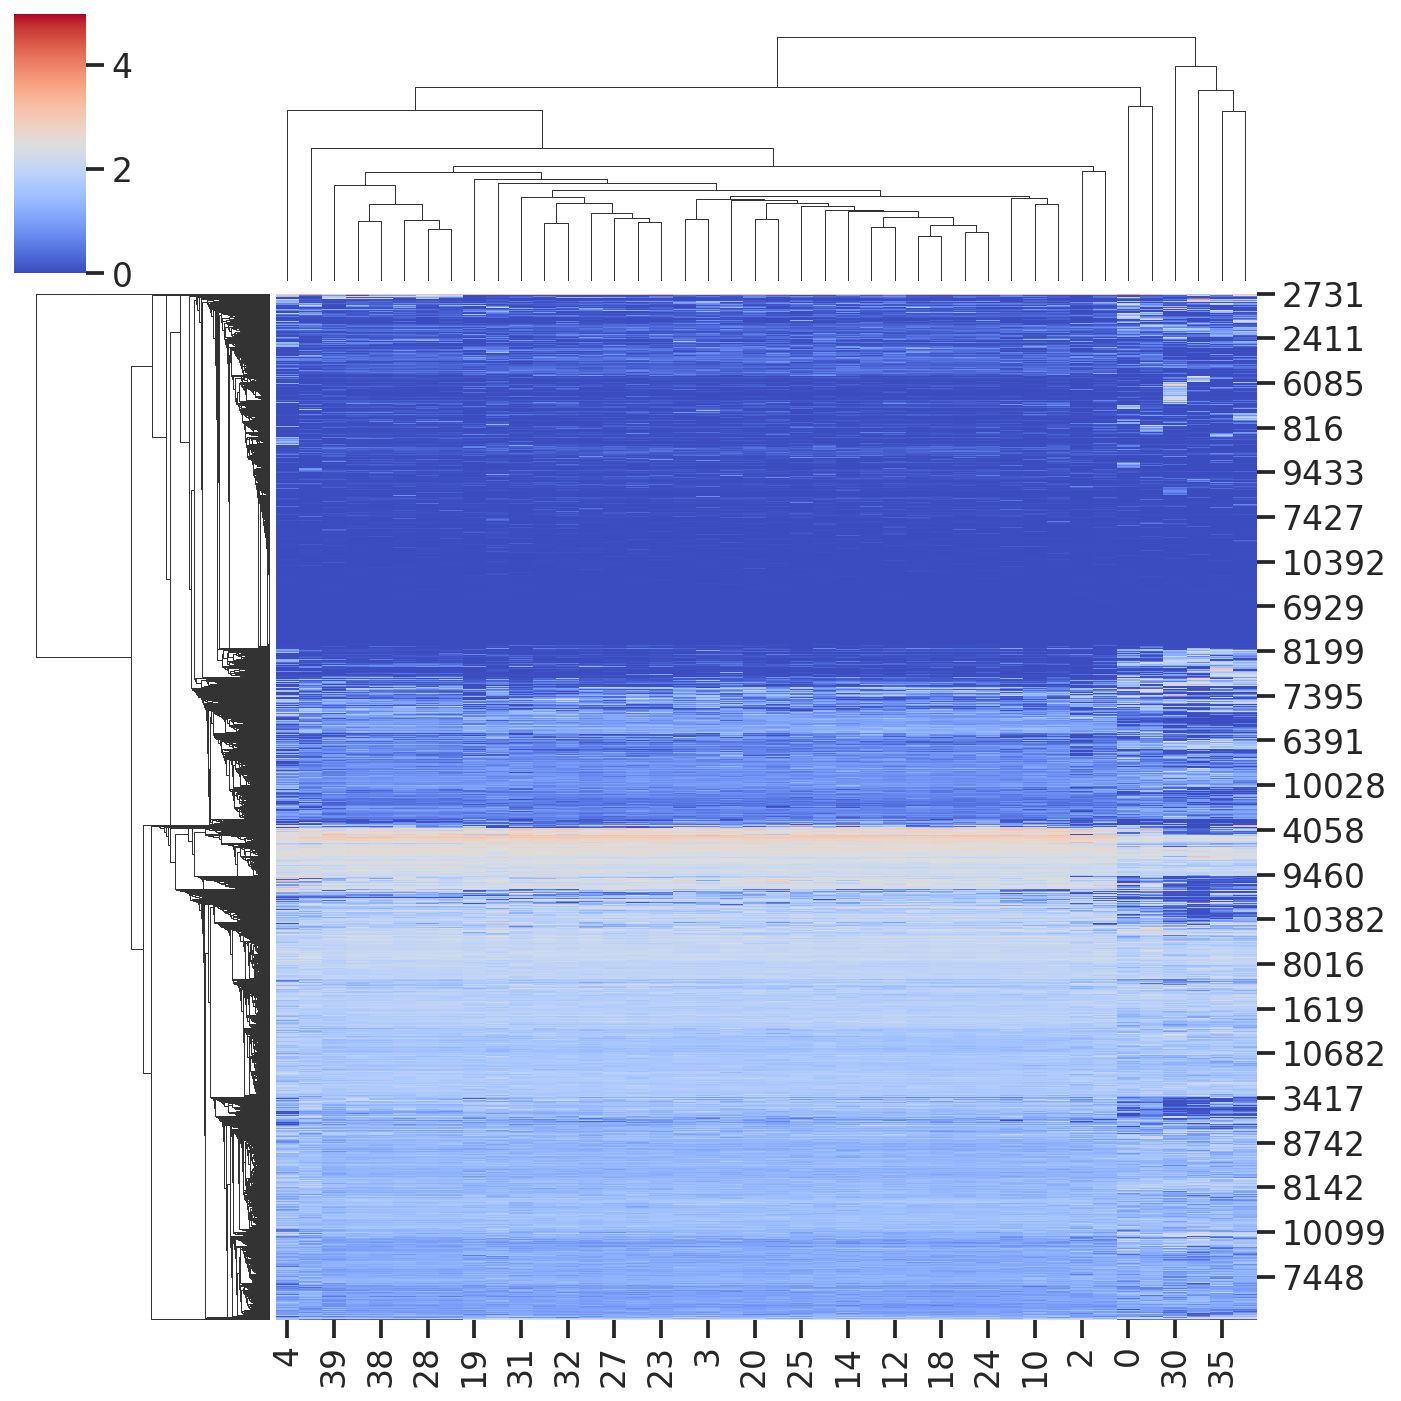

In [8]:
sns.clustermap(np.log10(ctrds_l3.T+1), cmap='coolwarm')

In [9]:
ctrds_l3.shape, ctrds_l1.shape
types_l3, types_l1

(array(['Astro', 'CA1-ProS', 'CA2-IG-FC', 'CA3', 'CR', 'CT SUB', 'Car3',
        'DG', 'Endo', 'L2 IT ENTl', 'L2 IT ENTm', 'L2/3 IT CTX',
        'L2/3 IT ENTl', 'L2/3 IT PPP', 'L2/3 IT RHP', 'L3 IT ENT',
        'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PPP', 'L5 PT CTX',
        'L5/6 IT TPE-ENT', 'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX',
        'L6 IT ENTl', 'L6b CTX', 'L6b/CT ENT', 'Lamp5', 'Meis2',
        'Micro-PVM', 'NP PPP', 'NP SUB', 'Oligo', 'Pvalb', 'SMC-Peri',
        'SUB-ProS', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
       dtype=object),
 array(['GABAergic', 'Glutamatergic', 'Non-Neuronal'], dtype=object))

In [10]:
types_l3tol1 = meta.groupby('subclass_label')['class_label'].first().loc[types_l3].values
types_l3tol1_code, types_l1_ = pd.factorize(types_l3tol1, sort=True)
assert np.all(types_l1_ == types_l1)
ctrds_diff = ctrds_l3 - ctrds_l1[types_l3tol1_code]
print(ctrds_diff.shape)

(42, 10861)


In [11]:
# select to change exc cells only
ctrds_diff[types_l3tol1 == 'Glutamatergic'].shape #, # _code

(29, 10861)

In [12]:
cond = np.logical_or(types_l3tol1 == 'Glutamatergic', types_l3tol1 == 'GABAergic')
ctrds_diff[cond].shape

(36, 10861)

In [13]:
# get a tree
# L5 - L3 - L1 - L0
levels = [
     'cluster_label', 
     'subclass_label', 
     # 'neighborhood_label',
     'class_label',
    ]
tree = meta.groupby(levels).size() #['Lim1'].mean().dropna()
tree = tree[tree!=0]
tree = tree.reset_index()[levels]
tree

,cluster_label,subclass_label,class_label
0,1_CR,CR,Glutamatergic
1,2_Meis2,Meis2,GABAergic
2,3_Meis2,Meis2,GABAergic
3,4_Meis2 HPF,Sncg,GABAergic
4,5_Lamp5 Lhx6,Lamp5,GABAergic
...,...,...,...
377,384_VLMC,VLMC,Non-Neuronal
378,385_VLMC,VLMC,Non-Neuronal
379,386_Micro-PVM,Micro-PVM,Non-Neuronal
380,387_Micro-PVM,Micro-PVM,Non-Neuronal


In [14]:
for col in tree:
    print(col, len(tree[col].unique()))

cluster_label 382
subclass_label 42
class_label 3


In [15]:
%%time
ctrds_lvl = []
types_lvl = []
# sub levels
for level in levels:
    print(level)
    # get centroids
    ctrds_, types_ = basicu.group_mean(X, meta[level].values)
    print(ctrds_.shape)
    print(types_.shape)
    ctrds_lvl.append(ctrds_)
    types_lvl.append(types_)
    
# level 0 (global)
ctrds_, types_ = basicu.group_mean(X, ['']*len(meta))
ctrds_lvl.append(ctrds_)
types_lvl.append(types_)

cluster_label
(382, 10861)
(382,)
subclass_label
(42, 10861)
(42,)
class_label
(3, 10861)
(3,)
CPU times: user 1min 18s, sys: 8.13 s, total: 1min 27s
Wall time: 10.5 s


In [16]:
%%time

# calculate Sb
w_lvl = [1,1,1] #
ngenes = ctrds_lvl[0].shape[1]
Sb = np.zeros((ngenes, ngenes))
ctrds_diff_lvl = [] # each sublevel gets a diff ctrds matrix
l2maxmean = 0 # for ease of scaling
for i in range(len(levels)):
    a = ctrds_lvl[i+1]
    b = ctrds_lvl[i]
    
    _types = types_lvl[i]
    _lc = levels[i]
    if i+1 < len(levels):
        _lu = levels[i+1]
        types_map1up = meta.groupby(_lc)[_lu].first().loc[_types].values
        types_map1up_code, _types_u = pd.factorize(types_map1up, sort=True)
        assert np.all(_types_u == types_lvl[i+1])
        
        ctrds_diff = b - a[types_map1up_code]
    else:
        ctrds_diff = b - np.repeat(a, len(b), axis=0)
    
    # save ctrds_diff for each level
    ctrds_diff_lvl.append(ctrds_diff)
    print(i, ctrds_diff.shape)
    
    # norm
    l2 = np.linalg.norm(ctrds_diff, axis=1) # no squared
    l2maxmean = max(np.mean(l2), l2maxmean) # max (across all levels) of the mean l2 per level
    # print(l2)
    
    ctrds_diff_norm = ctrds_diff/np.clip(l2.reshape(-1,1), 1e-5, None) # norm per cluster
    # l2n = np.linalg.norm(ctrds_diff_norm, axis=1) # l2n should be 1
    # print(l2n)
    
    Sb = Sb + w_lvl[i]*ctrds_diff_norm.T.dot(ctrds_diff_norm)
    
Sb = (l2maxmean**2)*Sb # restore unit/scale

0 (382, 10861)
1 (42, 10861)
2 (3, 10861)
CPU times: user 33.5 s, sys: 3.4 s, total: 36.9 s
Wall time: 5.25 s


In [17]:
# %%time
# Sb = ctrds_diff.T.dot(ctrds_diff)
# Sb.shape

In [18]:
mu = 100
w, rec = PNMF.get_DPNMF(X[:,:1000].T, 24, -Sb[:1000,:1000], mu,
                        init='normal', verbose=True, report_stride=30)

10-10 12:10:51 - 0, 8.82e-01
10-10 12:10:52 - 30, 5.63e-03
10-10 12:10:52 - 60, 3.40e-03
10-10 12:10:52 - 90, 7.37e-04
10-10 12:10:53 - 120, 2.00e-04
10-10 12:10:53 - 150, 1.60e-04
10-10 12:10:53 - 180, 3.78e-04
10-10 12:10:54 - 210, 2.56e-05
10-10 12:10:54 - 240, 2.19e-05
10-10 12:10:54 - 270, 1.91e-05
10-10 12:10:55 - 300, 2.40e-05
10-10 12:10:55 - 330, 1.43e-05
10-10 12:10:55 - 360, 1.29e-05
10-10 12:10:56 - 390, 1.42e-05
10-10 12:10:56 - 420, 1.90e-05
10-10 12:10:56 - 450, 2.43e-05
10-10 12:10:57 - 480, 1.96e-05
10-10 12:10:57 - 510, 1.02e-05


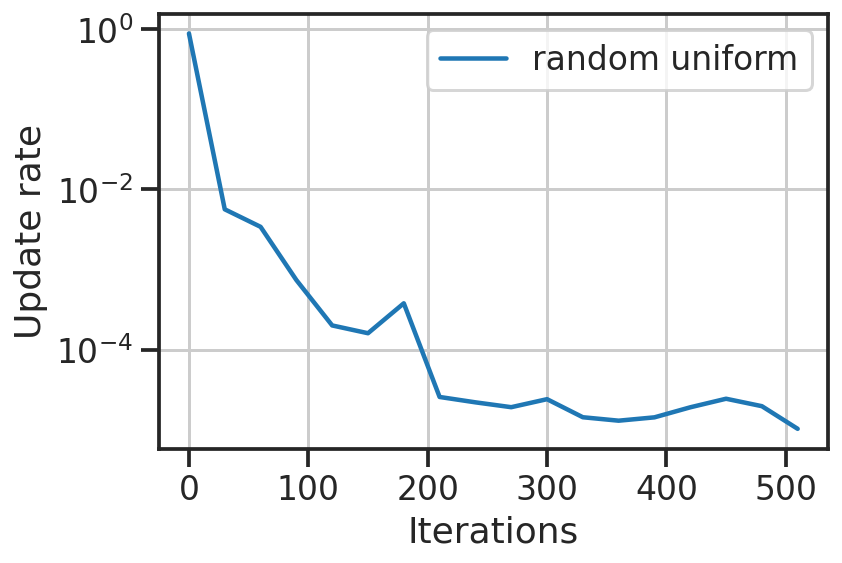

In [19]:
plt.plot(rec[:,0], rec[:,1], label='random uniform')
plt.xlabel('Iterations')
plt.ylabel('Update rate')
plt.legend()
plt.yscale('log')
# plt.xscale('log')

In [20]:
def plot(w, ax, vmax=None, reorder=True):
    if reorder:
        wnew, rows, cols = basicu.diag_matrix_rows(w)
    else:
        wnew = w
        
    sns.heatmap(
                # np.log10(wnew+1), 
                wnew,
                ax=ax, 
                cmap='rocket_r', 
                cbar_kws=dict(shrink=0.5),
                vmax=vmax,
               )

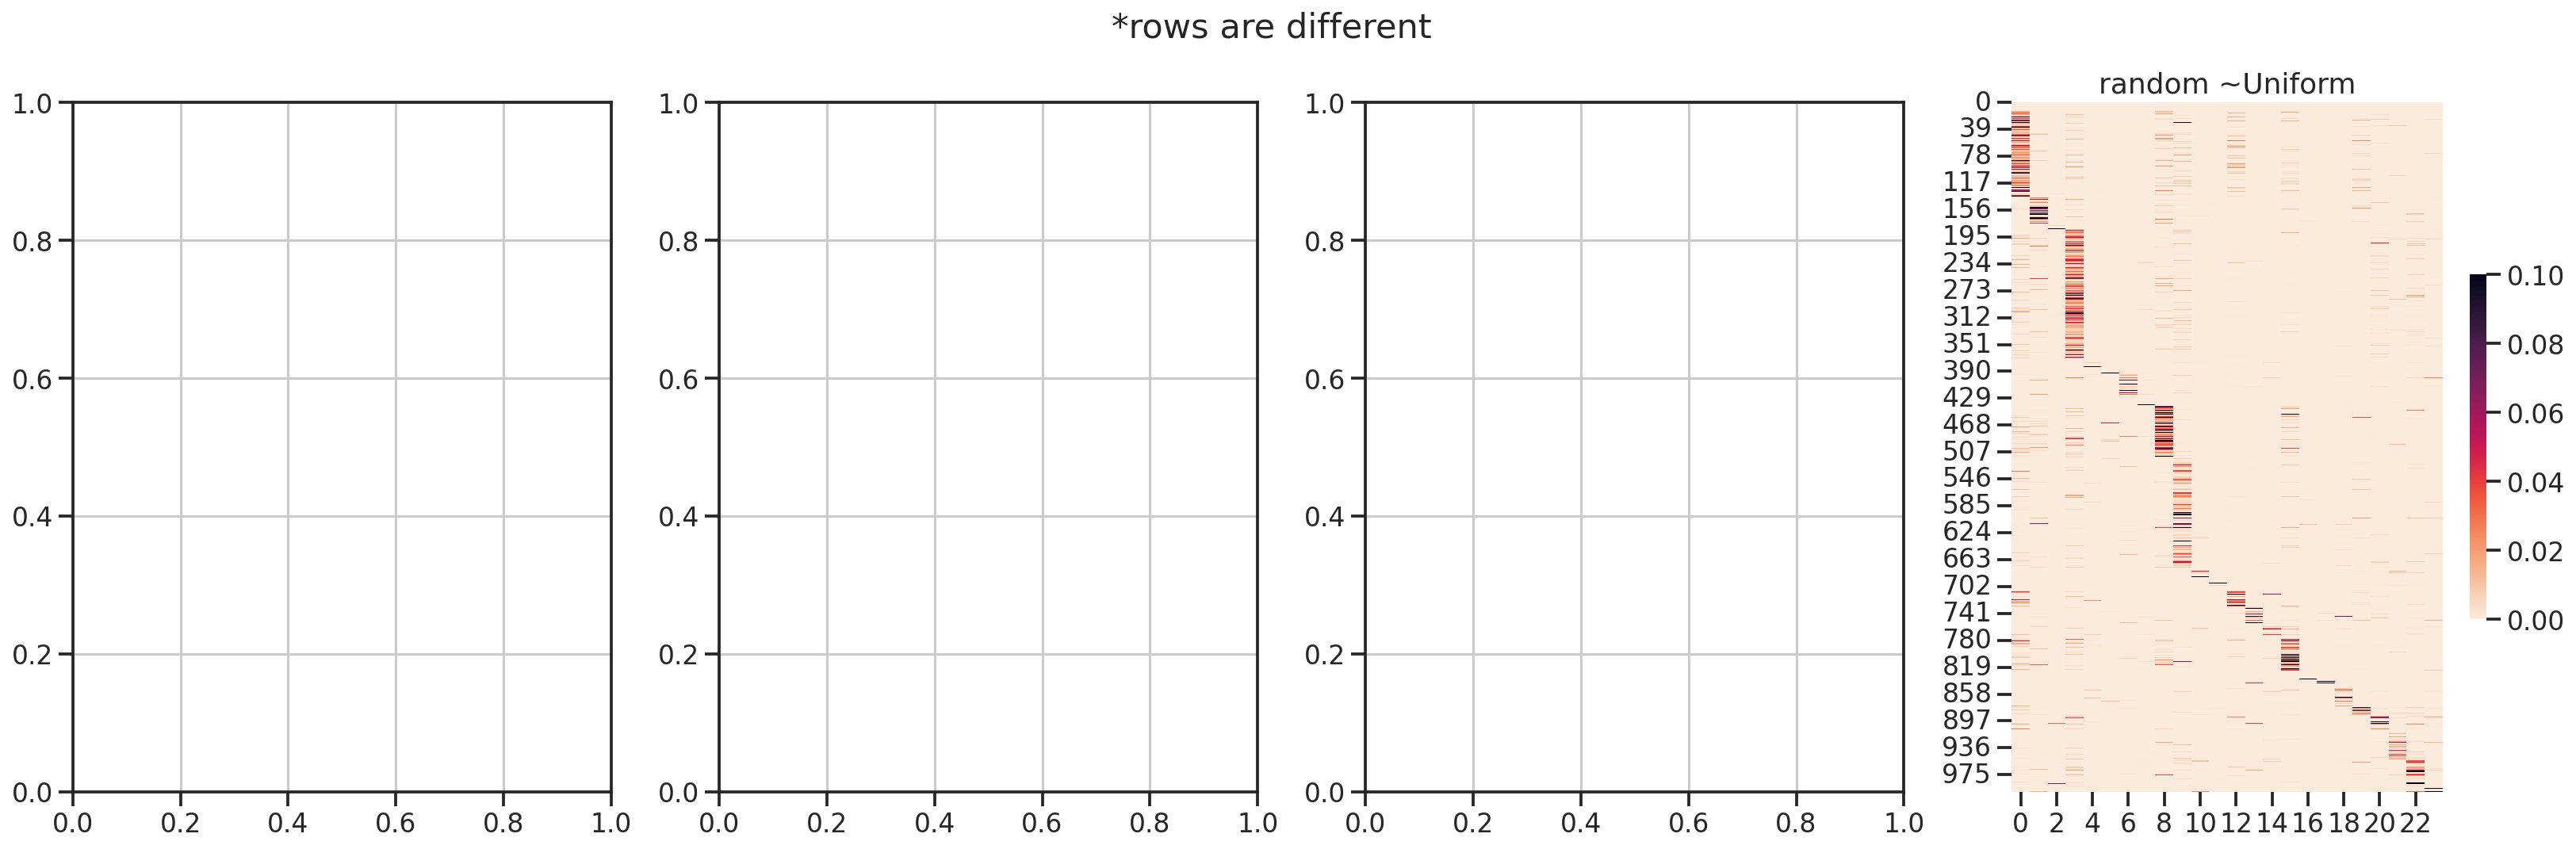

In [21]:
vmax = 0.1
# vmax = 0.03
fig, axs = plt.subplots(1, 4, figsize=(7*4,8))
# ax = axs[0]
# plot(w_pca, ax, vmax=vmax)
# ax.set_title('|PCA|')

# ax = axs[1]
# plot(w_p2x, ax, vmax=vmax)
# ax.set_title('PCA 2x')

# ax = axs[2]
# plot(w_nrm, ax, vmax=vmax)
# ax.set_title('random |~Normal|')

ax = axs[3]
plot(w, ax, vmax=vmax)
ax.set_title('random ~Uniform')
fig.suptitle('*rows are different')
plt.show()

In [22]:
# vmax = 0.1
# # vmax = 0.03
# # set the order
# wnew, rows, cols = basicu.diag_matrix_rows(w_pca)
# # wnew, rows, cols = basicu.diag_matrix_rows(w_p2x)

# fig, axs = plt.subplots(1, 4, figsize=(7*4,8))
# ax = axs[0]
# wnew = w_pca[rows]
# plot(wnew, ax, vmax=vmax, reorder=False)
# ax.set_title('|PCA|')

# ax = axs[1]
# wnew = w_p2x[rows]
# plot(wnew, ax, vmax=vmax, reorder=False)
# ax.set_title('PCA 2x')

# ax = axs[2]
# wnew = w_nrm[rows]
# plot(wnew, ax, vmax=vmax, reorder=False)
# ax.set_title('random |~Normal|')

# ax = axs[3]
# wnew = w_uni[rows]
# plot(wnew, ax, vmax=vmax, reorder=False)
# ax.set_title('random ~Uniform')

# fig.suptitle('*rows are aligned')
# plt.show()

# save and validate these


In [23]:
mus = [0, 10, 100, 1e3, 5e3]
ws = []
for mu in mus:
    print(mu)
    w, rec = PNMF.get_DPNMF(X[:,:1000].T, 24, -Sb[:1000,:1000], mu,
                            init='normal', verbose=True, report_stride=30)
    ws.append(w)
    

0


10-10 12:11:00 - 0, 8.88e-01
10-10 12:11:00 - 30, 7.64e-03
10-10 12:11:00 - 60, 1.06e-03
10-10 12:11:00 - 90, 1.45e-03
10-10 12:11:01 - 120, 7.63e-04
10-10 12:11:01 - 150, 2.78e-04
10-10 12:11:02 - 180, 1.86e-04
10-10 12:11:02 - 210, 2.35e-04
10-10 12:11:02 - 240, 2.94e-05
10-10 12:11:02 - 270, 2.33e-05
10-10 12:11:03 - 300, 9.55e-05
10-10 12:11:03 - 330, 1.88e-05
10-10 12:11:03 - 360, 1.36e-05


10


10-10 12:11:04 - 0, 8.88e-01
10-10 12:11:05 - 30, 5.56e-03
10-10 12:11:05 - 60, 1.20e-03
10-10 12:11:05 - 90, 1.17e-03
10-10 12:11:06 - 120, 1.68e-03
10-10 12:11:06 - 150, 3.24e-04
10-10 12:11:06 - 180, 1.20e-04
10-10 12:11:07 - 210, 6.24e-05
10-10 12:11:07 - 240, 5.64e-05
10-10 12:11:07 - 270, 3.24e-05
10-10 12:11:07 - 300, 1.85e-05
10-10 12:11:08 - 330, 1.44e-05
10-10 12:11:08 - 360, 9.99e-06


100


10-10 12:11:09 - 0, 8.82e-01
10-10 12:11:09 - 30, 5.63e-03
10-10 12:11:10 - 60, 3.40e-03
10-10 12:11:10 - 90, 7.37e-04
10-10 12:11:10 - 120, 2.00e-04
10-10 12:11:11 - 150, 1.60e-04
10-10 12:11:11 - 180, 3.78e-04
10-10 12:11:12 - 210, 2.56e-05
10-10 12:11:12 - 240, 2.19e-05
10-10 12:11:12 - 270, 1.91e-05
10-10 12:11:13 - 300, 2.40e-05
10-10 12:11:13 - 330, 1.43e-05
10-10 12:11:13 - 360, 1.29e-05
10-10 12:11:14 - 390, 1.42e-05
10-10 12:11:14 - 420, 1.90e-05
10-10 12:11:15 - 450, 2.43e-05
10-10 12:11:15 - 480, 1.96e-05
10-10 12:11:16 - 510, 1.02e-05


1000.0


10-10 12:11:19 - 0, 8.38e-01
10-10 12:11:19 - 30, 3.71e-01
10-10 12:11:20 - 60, 3.68e-01
10-10 12:11:20 - 90, 3.63e-01
10-10 12:11:20 - 120, 3.60e-01
10-10 12:11:21 - 150, 3.47e-01
10-10 12:11:21 - 180, 3.40e-01
10-10 12:11:21 - 210, 3.35e-01
10-10 12:11:22 - 240, 1.65e-01
10-10 12:11:22 - 270, 1.78e-01
10-10 12:11:23 - 300, 1.73e-01
10-10 12:11:23 - 330, 1.70e-01
10-10 12:11:24 - 360, 1.67e-01
10-10 12:11:24 - 390, 1.64e-01
10-10 12:11:25 - 420, 1.61e-01
10-10 12:11:25 - 450, 1.57e-01
10-10 12:11:26 - 480, 1.54e-01
10-10 12:11:26 - 510, 1.51e-01
10-10 12:11:26 - 540, 1.48e-01
10-10 12:11:27 - 570, 1.46e-01
10-10 12:11:27 - 600, 1.44e-01
10-10 12:11:28 - 630, 1.42e-01
10-10 12:11:28 - 660, 1.39e-01
10-10 12:11:29 - 690, 1.37e-01
10-10 12:11:30 - 720, 1.36e-01
10-10 12:11:30 - 750, 1.34e-01
10-10 12:11:31 - 780, 1.32e-01
10-10 12:11:31 - 810, 1.30e-01
10-10 12:11:31 - 840, 1.29e-01
10-10 12:11:32 - 870, 1.27e-01
10-10 12:11:32 - 900, 1.25e-01
10-10 12:11:33 - 930, 1.24e-01
10-10 12:11:3

5000.0


10-10 12:11:34 - 0, 7.27e-01
10-10 12:11:35 - 30, 2.18e+00
10-10 12:11:35 - 60, 2.51e+00
10-10 12:11:36 - 90, 2.45e+00
10-10 12:11:36 - 120, 2.43e+00
10-10 12:11:37 - 150, 2.43e+00
10-10 12:11:37 - 180, 2.43e+00
10-10 12:11:38 - 210, 2.44e+00
10-10 12:11:38 - 240, 2.45e+00
10-10 12:11:38 - 270, 2.48e+00
10-10 12:11:39 - 300, 2.51e+00
10-10 12:11:39 - 330, 2.55e+00
10-10 12:11:39 - 360, 2.59e+00
10-10 12:11:40 - 390, 2.62e+00
10-10 12:11:40 - 420, 2.65e+00
10-10 12:11:41 - 450, 2.68e+00
10-10 12:11:41 - 480, 2.71e+00
10-10 12:11:41 - 510, 2.73e+00
10-10 12:11:42 - 540, 2.75e+00
10-10 12:11:42 - 570, 2.77e+00
10-10 12:11:43 - 600, 2.75e+00
10-10 12:11:43 - 630, 2.74e+00
10-10 12:11:43 - 660, 2.72e+00
10-10 12:11:44 - 690, 2.71e+00
10-10 12:11:44 - 720, 2.70e+00
10-10 12:11:44 - 750, 2.70e+00
10-10 12:11:45 - 780, 2.69e+00
10-10 12:11:45 - 810, 2.74e+00
10-10 12:11:45 - 840, 2.62e+00
10-10 12:11:46 - 870, 2.54e+00
10-10 12:11:46 - 900, 2.48e+00
10-10 12:11:47 - 930, 2.44e+00
10-10 12:11:4

In [24]:
output = os.path.join(res_dir, "smrt_X_DPNMF_test_tree.h5ad")
res_adata = anndata.AnnData(ws[0])
for mu, w in zip(mus, ws):
    res_adata.layers[f'w_mu{mu:.1e}'] = w
res_adata

AnnData object with n_obs × n_vars = 1000 × 24
    layers: 'w_mu0.0e+00', 'w_mu1.0e+01', 'w_mu1.0e+02', 'w_mu1.0e+03', 'w_mu5.0e+03'

In [25]:
res_adata.write(output)

In [26]:
b = anndata.read(output) #, backed='r')
b

AnnData object with n_obs × n_vars = 1000 × 24
    layers: 'w_mu0.0e+00', 'w_mu1.0e+01', 'w_mu1.0e+02', 'w_mu1.0e+03', 'w_mu5.0e+03'

# second try

In [27]:
%%time

# calculate Sb
w_lvl = [1.0/382, 1.0/44 , 1.0/3] #
w_lvl = w_lvl/np.mean(w_lvl)
print(w_lvl)

ngenes = ctrds_lvl[0].shape[1]
Sb = np.zeros((ngenes, ngenes))
ctrds_diff_lvl = [] # each sublevel gets a diff ctrds matrix
l2maxmean = 0 # for ease of scaling
for i in range(len(levels)):
    a = ctrds_lvl[i+1]
    b = ctrds_lvl[i]
    
    _types = types_lvl[i]
    _lc = levels[i]
    if i+1 < len(levels):
        _lu = levels[i+1]
        types_map1up = meta.groupby(_lc)[_lu].first().loc[_types].values
        types_map1up_code, _types_u = pd.factorize(types_map1up, sort=True)
        assert np.all(_types_u == types_lvl[i+1])
        
        ctrds_diff = b - a[types_map1up_code]
    else:
        ctrds_diff = b - np.repeat(a, len(b), axis=0)
    
    # save ctrds_diff for each level
    ctrds_diff_lvl.append(ctrds_diff)
    print(i, ctrds_diff.shape)
    
    # norm
    l2 = np.linalg.norm(ctrds_diff, axis=1) # no squared
    l2maxmean = max(np.mean(l2), l2maxmean) # max (across all levels) of the mean l2 per level
    # print(l2)
    
    ctrds_diff_norm = ctrds_diff/np.clip(l2.reshape(-1,1), 1e-5, None) # norm per cluster
    # l2n = np.linalg.norm(ctrds_diff_norm, axis=1) # l2n should be 1
    # print(l2n)
    
    Sb = Sb + w_lvl[i]*ctrds_diff_norm.T.dot(ctrds_diff_norm)
    
Sb = (l2maxmean**2)*Sb # restore unit/scale

[0.02189539 0.19009178 2.78801283]
0 (382, 10861)
1 (42, 10861)
2 (3, 10861)
CPU times: user 31.6 s, sys: 3.59 s, total: 35.2 s
Wall time: 4.82 s


In [28]:
mus = [0, 10, 100, 1e3, 5e3]
ws = []
for mu in mus:
    print(mu)
    w, rec = PNMF.get_DPNMF(X[:,:1000].T, 24, -Sb[:1000,:1000], mu,
                            init='normal', verbose=True, report_stride=30)
    ws.append(w)
    

0


10-10 12:11:54 - 0, 8.88e-01
10-10 12:11:54 - 30, 7.64e-03
10-10 12:11:54 - 60, 1.06e-03
10-10 12:11:55 - 90, 1.45e-03
10-10 12:11:55 - 120, 7.63e-04
10-10 12:11:55 - 150, 2.78e-04
10-10 12:11:56 - 180, 1.86e-04
10-10 12:11:56 - 210, 2.35e-04
10-10 12:11:56 - 240, 2.94e-05
10-10 12:11:56 - 270, 2.33e-05
10-10 12:11:57 - 300, 9.55e-05
10-10 12:11:57 - 330, 1.88e-05
10-10 12:11:58 - 360, 1.36e-05


10


10-10 12:11:59 - 0, 8.88e-01
10-10 12:11:59 - 30, 7.49e-03
10-10 12:12:00 - 60, 1.06e-03
10-10 12:12:00 - 90, 1.41e-03
10-10 12:12:01 - 120, 7.96e-04
10-10 12:12:01 - 150, 2.78e-04
10-10 12:12:01 - 180, 1.91e-04
10-10 12:12:02 - 210, 2.26e-04
10-10 12:12:02 - 240, 2.94e-05
10-10 12:12:03 - 270, 2.35e-05
10-10 12:12:03 - 300, 9.18e-05
10-10 12:12:04 - 330, 1.86e-05
10-10 12:12:04 - 360, 1.36e-05


100


10-10 12:12:05 - 0, 8.88e-01
10-10 12:12:05 - 30, 6.49e-03
10-10 12:12:06 - 60, 1.07e-03
10-10 12:12:06 - 90, 1.05e-03
10-10 12:12:06 - 120, 1.23e-03
10-10 12:12:06 - 150, 2.77e-04
10-10 12:12:07 - 180, 2.41e-04
10-10 12:12:07 - 210, 1.50e-04
10-10 12:12:07 - 240, 2.95e-05
10-10 12:12:08 - 270, 2.31e-05
10-10 12:12:08 - 300, 7.42e-05
10-10 12:12:08 - 330, 1.68e-05
10-10 12:12:08 - 360, 1.24e-05


1000.0


10-10 12:12:09 - 0, 8.84e-01
10-10 12:12:10 - 30, 5.07e-03
10-10 12:12:10 - 60, 1.61e-03
10-10 12:12:11 - 90, 1.54e-03
10-10 12:12:11 - 120, 9.23e-04
10-10 12:12:11 - 150, 1.35e-04
10-10 12:12:12 - 180, 1.12e-04
10-10 12:12:12 - 210, 8.78e-05
10-10 12:12:12 - 240, 1.35e-04
10-10 12:12:13 - 270, 2.11e-04
10-10 12:12:13 - 300, 7.15e-05
10-10 12:12:14 - 330, 6.28e-04
10-10 12:12:14 - 360, 9.97e-05
10-10 12:12:14 - 390, 2.84e-05
10-10 12:12:15 - 420, 4.07e-05


5000.0


10-10 12:12:16 - 0, 8.69e-01
10-10 12:12:16 - 30, 8.80e-03
10-10 12:12:17 - 60, 3.01e-03
10-10 12:12:17 - 90, 5.91e-04
10-10 12:12:18 - 120, 2.35e-04
10-10 12:12:18 - 150, 2.42e-03
10-10 12:12:19 - 180, 1.57e-04
10-10 12:12:19 - 210, 2.81e-03
10-10 12:12:20 - 240, 2.71e-05
10-10 12:12:20 - 270, 3.12e-05
10-10 12:12:21 - 300, 1.91e-05
10-10 12:12:21 - 330, 4.24e-05
10-10 12:12:21 - 360, 1.28e-05


In [29]:
output = os.path.join(res_dir, "smrt_X_DPNMF_test_tree_balanced_levels.h5ad")
res_adata = anndata.AnnData(ws[0])
for mu, w in zip(mus, ws):
    res_adata.layers[f'w_mu{mu:.1e}'] = w
res_adata

AnnData object with n_obs × n_vars = 1000 × 24
    layers: 'w_mu0.0e+00', 'w_mu1.0e+01', 'w_mu1.0e+02', 'w_mu1.0e+03', 'w_mu5.0e+03'

In [30]:
res_adata.write(output)

In [31]:
b = anndata.read(output) #, backed='r')
b

AnnData object with n_obs × n_vars = 1000 × 24
    layers: 'w_mu0.0e+00', 'w_mu1.0e+01', 'w_mu1.0e+02', 'w_mu1.0e+03', 'w_mu5.0e+03'